In [153]:
import os
import string
import json
import warnings
from datetime import datetime, timedelta
from collections import Counter
import yfinance as yf

# analitics and visual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go


# NLP 
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# utility
from dotenv import load_dotenv
from sqlalchemy import create_engine
from tqdm import tqdm
from IPython.core.display import display, HTML, clear_output


tqdm.pandas()
display(HTML("<style>.container { width:90% !important; }</style>"))
warnings.filterwarnings("ignore")


load_dotenv()
db_config = {
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'database': os.getenv('DB_NAME')
}

db_url = f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(db_url, connect_args={'connect_timeout': 600})

news_data_query = """
    SELECT n.*, CASE WHEN request_id = 2 THEN 'index' ELSE 'oil' END AS request_category
    FROM news_data n
    WHERE STR_TO_DATE(CONCAT(YEAR(published_timestamp), WEEK(published_timestamp, 1), ' Monday'), '%%X%%V %%W') = '{}'
"""

market_data_query = """
    SELECT m.*, CASE WHEN asset_name in ('WTI','BRENT') THEN 'oil' else 'index' END AS request_category
    FROM market_data m
"""

# unique weeks only for batch creating before download
weeks_query = """
SELECT DISTINCT
    STR_TO_DATE(CONCAT(YEAR(published_timestamp), WEEK(published_timestamp, 1), ' Monday'), '%%X%%V %%W') AS week_start
FROM news_data
ORDER BY week_start
"""

all_data = []

with engine.connect() as connection:
    weeks = pd.read_sql(weeks_query, con=connection)["week_start"]
    market_data = pd.read_sql(market_data_query,con=connection)
    
for week_start in tqdm(weeks):
    with engine.connect() as connection:
        batch_data = pd.read_sql(news_data_query.format(week_start), con=connection)
        all_data.append(batch_data)
        
data = pd.concat(all_data, ignore_index=True)
data.head(2)

100%|███████████████████████████████████████████| 67/67 [07:55<00:00,  7.09s/it]


,news_provider,thread_uuid,post_uuid,site,title,published_timestamp,country,performance_score,domain_rank,language,sentiment,article_text,request_id,entities,request_category
0,webzio,37a910ff5850fef574f116f6f262a50285d14188,37a910ff5850fef574f116f6f262a50285d14188,wired.com,This Scorching Summer Is Taking a Toll on Your...,2023-08-04 15:00:00,US,0,147,english,,"Maryn McKenna\nScience Aug 4, 2023 7:00 AM Thi...",4,"{""persons"": [{""name"": ""maryn mckenna"", ""sentim...",oil
1,webzio,52965d6db46a20f5c022a666d658f05be382219e,52965d6db46a20f5c022a666d658f05be382219e,cnn.com,Blue-water ambitions: Is China looking beyond ...,2023-08-02 19:02:00,US,0,75,english,,"Seoul, South Korea CNN — China has built the w...",4,"{""persons"": [], ""locations"": [{""name"": ""south ...",oil


In [126]:
# take FinBert model

tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [154]:
# apply FinBert model

def get_finbert_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    sentiment = torch.argmax(probabilities, dim=1).item()
    return sentiment

data['finbert_sentiment'] = data['article_text'].progress_apply(get_finbert_sentiment)
data.loc[data.finbert_sentiment==2,'finbert_sentiment'] = -1

data[['title', 'finbert_sentiment']]

100%|█████████████████████████████████| 120668/120668 [4:40:34<00:00,  7.17it/s]


,title,finbert_sentiment
0,This Scorching Summer Is Taking a Toll on Your...,0
1,Blue-water ambitions: Is China looking beyond ...,0
2,Huge theft rocks Europe’s largest copper producer,0
3,Books about Science Chosen by Scientists for N...,0
4,NHL agency 2023 tracker: Canucks sign forward ...,0
...,...,...
120663,"""Empowering Advertising Through Innovation: A ...",1
120664,"""Transforming Spaces: The Role of an Administr...",0
120665,"""Join Apple's Next Frontier: Seeking Data Scie...",1
120666,"""Budget Cuts and Economic Growth: Analyzing Pa...",0


In [268]:
# creating a continuous sequence in df

tickers = ['CL=F', 'BZ=F', 'SPY', 'QQQ']
data['published_timestamp'] = pd.to_datetime(data['published_timestamp'], utc=True)
cutoff_time = pd.Timestamp('21:00:00').time()

# if published time after cutoff using next date
def determine_effective_date(row):
    published_time = row['published_timestamp'].time()
    published_date = row['published_timestamp'].date()
    if published_time <= cutoff_time:
        return published_date
    else:
        return published_date + timedelta(days=1)

data['effective_date'] = data.apply(determine_effective_date, axis=1)
market_data['business_date'] = pd.to_datetime(market_data['business_date']).dt.date

# date range
min_date = min(data['effective_date'].min(), market_data['business_date'].min())
max_date = max(data['effective_date'].max(), market_data['business_date'].max())
all_dates = pd.date_range(start=min_date, end=max_date).date

# full frame with all dates
all_combinations = pd.MultiIndex.from_product([tickers, all_dates], names=['ticker', 'business_date']).to_frame(index=False)
market_data_full = pd.merge(all_combinations, market_data, on=['ticker', 'business_date'], how='left')

# filling None
market_data_full = market_data_full.sort_values(['ticker', 'business_date']).reset_index(drop=True)
market_data_full['is_trading_day'] = market_data_full['close'].notna()
market_data_full.fillna(method='ffill', inplace=True)



# if effective date is not trading date then using next trading date
def get_next_trading_day(effective_date, request_category):
    ticker_data = market_data_full[market_data_full['request_category'] == request_category]
    trading_days = ticker_data[ticker_data['is_trading_day']]['business_date']
    future_trading_days = trading_days[trading_days >= effective_date]
    if not future_trading_days.empty:
        return future_trading_days.iloc[0]
    else:
        return None

def assign_business_date(row):
    effective_date = row['effective_date']
    request_category = row['request_category']
    is_trading_day = market_data_full[
        (market_data_full['request_category'] == request_category) &
        (market_data_full['business_date'] == effective_date)
    ]['is_trading_day'].values
    if is_trading_day.size > 0 and is_trading_day[0]:
        return effective_date
    else:
        next_trading_day = get_next_trading_day(effective_date, request_category)
        return next_trading_day

data['business_date'] = data.apply(assign_business_date, axis=1)


# same type
data['business_date'] = pd.to_datetime(data['business_date']).dt.date.astype(str)
market_data_full['business_date'] = pd.to_datetime(market_data_full['business_date']).dt.date.astype(str)

data_full = pd.merge(market_data_full, data, on=['request_category', 'business_date'], how='left')
data_full = data_full.loc[data_full.business_date>=data.business_date.min()]

data_full.head()

,ticker,business_date,open,high,low,close,adj_close,volume,asset_name,created_datetime,...,country,performance_score,domain_rank,language,sentiment,article_text,request_id,entities,finbert_sentiment,effective_date
0,BZ=F,2022-01-03,77.940002,79.279999,77.040001,78.980003,78.980003,27224.0,BRENT,2024-11-01 12:03:51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BZ=F,2022-01-04,78.949997,80.550003,78.599998,80.000000,80.000000,31321.0,BRENT,2024-11-01 12:03:51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BZ=F,2022-01-05,80.080002,81.489998,79.550003,80.800003,80.800003,35152.0,BRENT,2024-11-01 12:03:51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BZ=F,2022-01-06,80.150002,82.839996,79.629997,81.989998,81.989998,41582.0,BRENT,2024-11-01 12:03:51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BZ=F,2022-01-07,82.059998,82.989998,81.440002,81.750000,81.750000,29501.0,BRENT,2024-11-01 12:03:51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [466]:
# we need to access quality of recieved sentiment via weight based on domain_rank
data_full['weight'] = 1 / data_full['domain_rank']

# making aggregated df
daily_sentiment = data_full.groupby(['ticker','asset_name','business_date', 'close'], as_index=False)\
    .agg(avg_finbert_sentiment=('finbert_sentiment', 'mean'))

# applying weight of domain_rank to sentiment_numeric
weighted_finbert_sentiment = data_full.groupby(['ticker', 'asset_name', 'business_date']).apply(
    lambda x: (x['finbert_sentiment'] * x['weight']).sum() / x['weight'].sum()
).reset_index(name='weighted_avg_finbert_sentiment')

# std
sentiment_std = data_full.groupby(['ticker','asset_name', 'business_date'])['finbert_sentiment'].std().reset_index(name='sentiment_std')

# merge std and weighted sentiment
daily_sentiment = daily_sentiment.merge(sentiment_std, on=['ticker','asset_name', 'business_date'], how='left')
daily_sentiment = daily_sentiment.merge(weighted_finbert_sentiment, on=['ticker','asset_name', 'business_date'], how='left')

daily_sentiment = daily_sentiment.sort_values(['ticker', 'asset_name', 'business_date'])

for lag in [1, 2, 3, 7]:
    daily_sentiment[f'avg_finbert_sentiment_lag{lag}'] = daily_sentiment.groupby('ticker')['avg_finbert_sentiment'].shift(lag)
    daily_sentiment[f'weighted_avg_finbert_sentiment_lag{lag}'] = daily_sentiment.groupby('ticker')['weighted_avg_finbert_sentiment'].shift(lag)
    daily_sentiment[f'avg_finbert_sentiment_diff{lag}'] = daily_sentiment['avg_finbert_sentiment'] - daily_sentiment[f'avg_finbert_sentiment_lag{lag}']
    daily_sentiment[f'weighted_avg_finbert_sentiment_diff{lag}'] = daily_sentiment['weighted_avg_finbert_sentiment'] - daily_sentiment[f'weighted_avg_finbert_sentiment_lag{lag}']

    
    
# sentiment_acceleration
daily_sentiment['finbert_sentiment_acceleration'] = daily_sentiment['avg_finbert_sentiment_diff1'] - daily_sentiment.groupby('ticker')['avg_finbert_sentiment_diff1'].shift(1)
daily_sentiment['weighted_finbert_sentiment_acceleration'] = daily_sentiment['weighted_avg_finbert_sentiment_diff1'] - daily_sentiment.groupby('ticker')['weighted_avg_finbert_sentiment_diff1'].shift(1)

# rolling average
for window in [7, 15, 30]:
    daily_sentiment[f'avg_finbert_sentiment_ma_{window}'] = daily_sentiment.groupby('ticker')['avg_finbert_sentiment'].transform(lambda x: x.rolling(window, min_periods=1, center=False).mean())
    daily_sentiment[f'weighted_avg_finbert_sentiment_ma_{window}'] = daily_sentiment.groupby('ticker')['weighted_avg_finbert_sentiment'].transform(lambda x: x.rolling(window, min_periods=1, center=False).mean())

# how price changed
daily_sentiment.sort_values(['ticker','asset_name', 'business_date'], inplace=True)
daily_sentiment['price_change'] = daily_sentiment.groupby('ticker')['close'].diff()
daily_sentiment = daily_sentiment.groupby(['ticker', 'asset_name'], group_keys=False).apply(lambda x: x.ffill())



# keep only news_data related tickers
daily_sentiment = daily_sentiment.loc[daily_sentiment.asset_name.isin(['BRENT','WTI'])]


# making a huge shift in major rolling mean values
daily_sentiment['avg_finbert_sentiment_ma_30_shifted_45'] = (
    daily_sentiment.groupby(['ticker', 'asset_name'])['avg_finbert_sentiment_ma_30']
    .shift(45)
)
daily_sentiment['weighted_avg_finbert_sentiment_ma_30_shifted_45'] = (
    daily_sentiment.groupby(['ticker', 'asset_name'])['weighted_avg_finbert_sentiment_ma_30']
    .shift(45)
)

# cut off everything earlier 2023-11-15 cause from that moment rolling windows with shift start work correctly
daily_sentiment = daily_sentiment.groupby(['ticker', 'asset_name']).apply(lambda x: x.iloc[105:]).reset_index(drop=True)
daily_sentiment['business_date'] = pd.to_datetime(daily_sentiment['business_date'])
daily_sentiment

,ticker,asset_name,business_date,close,avg_finbert_sentiment,sentiment_std,weighted_avg_finbert_sentiment,avg_finbert_sentiment_lag1,weighted_avg_finbert_sentiment_lag1,avg_finbert_sentiment_diff1,...,weighted_finbert_sentiment_acceleration,avg_finbert_sentiment_ma_7,weighted_avg_finbert_sentiment_ma_7,avg_finbert_sentiment_ma_15,weighted_avg_finbert_sentiment_ma_15,avg_finbert_sentiment_ma_30,weighted_avg_finbert_sentiment_ma_30,price_change,avg_finbert_sentiment_ma_30_shifted_45,weighted_avg_finbert_sentiment_ma_30_shifted_45
0,BZ=F,BRENT,2023-11-15,81.180000,0.188406,0.526980,0.147026,0.151329,0.113070,0.037077,...,-0.070370,0.114990,0.074302,0.124475,0.072338,0.106174,0.054185,-1.290001,0.063315,0.011712
1,BZ=F,BRENT,2023-11-16,77.419998,0.118699,0.504596,0.070196,0.188406,0.147026,-0.069707,...,-0.110786,0.114022,0.074866,0.123320,0.074358,0.104979,0.053315,-3.760002,0.064124,0.011392
2,BZ=F,BRENT,2023-11-17,80.610001,0.053232,0.506171,0.036326,0.118699,0.070196,-0.065467,...,0.042959,0.106818,0.075072,0.113429,0.065694,0.105190,0.054508,3.190002,0.064204,0.011301
3,BZ=F,BRENT,2023-11-18,80.610001,0.053232,0.506171,0.036326,0.053232,0.036326,-0.065467,...,0.042959,0.106818,0.075072,0.108623,0.065731,0.108062,0.058564,0.000000,0.065608,0.013340
4,BZ=F,BRENT,2023-11-19,80.610001,0.053232,0.506171,0.036326,0.053232,0.036326,-0.065467,...,0.042959,0.106818,0.075072,0.108623,0.065731,0.113465,0.064331,0.000000,0.066370,0.015960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,CL=F,WTI,2024-11-03,69.260002,0.056338,0.557733,0.068954,0.056338,0.068954,0.056338,...,0.104918,0.031676,0.015111,0.053691,0.061479,0.105111,0.065488,0.000000,0.089162,0.011819
714,CL=F,WTI,2024-11-04,69.260002,0.056338,0.557733,0.068954,0.056338,0.068954,0.056338,...,0.104918,0.016381,0.007077,0.053691,0.061479,0.105111,0.065488,0.000000,0.091098,0.011748
715,CL=F,WTI,2024-11-05,69.260002,0.056338,0.557733,0.068954,0.056338,0.068954,0.056338,...,0.104918,0.028169,0.020529,0.064190,0.083117,0.105111,0.065488,0.000000,0.089834,0.011587
716,CL=F,WTI,2024-11-06,69.260002,0.056338,0.557733,0.068954,0.056338,0.068954,0.056338,...,0.104918,0.056338,0.068954,0.073360,0.063896,0.110950,0.069126,0.000000,0.088502,0.009400


In [467]:
target_assets = ['BRENT', 'WTI']
print(f'Correlation table for {target_assets[0]} and {target_assets[1]}')
daily_sentiment.iloc[30:-60].loc[daily_sentiment.asset_name.isin(target_assets)].select_dtypes(['float','int'])\
               .corr()[['close','price_change']]\
               .reset_index()\
               .rename(columns={'index':'feature'})\
               .sort_values('close').dropna()

Correlation table for BRENT and WTI


,feature,close,price_change
11,weighted_avg_finbert_sentiment_diff2,-0.180434,0.049604
10,avg_finbert_sentiment_diff2,-0.179535,0.047968
2,sentiment_std,-0.127008,-0.055603
6,avg_finbert_sentiment_diff1,-0.042674,0.013712
7,weighted_avg_finbert_sentiment_diff1,-0.035857,0.048428
20,finbert_sentiment_acceleration,-0.011042,0.100060
16,avg_finbert_sentiment_lag7,0.005467,0.013202
21,weighted_finbert_sentiment_acceleration,0.006453,0.070210
15,weighted_avg_finbert_sentiment_diff3,0.006851,0.014863
14,avg_finbert_sentiment_diff3,0.020473,0.087329


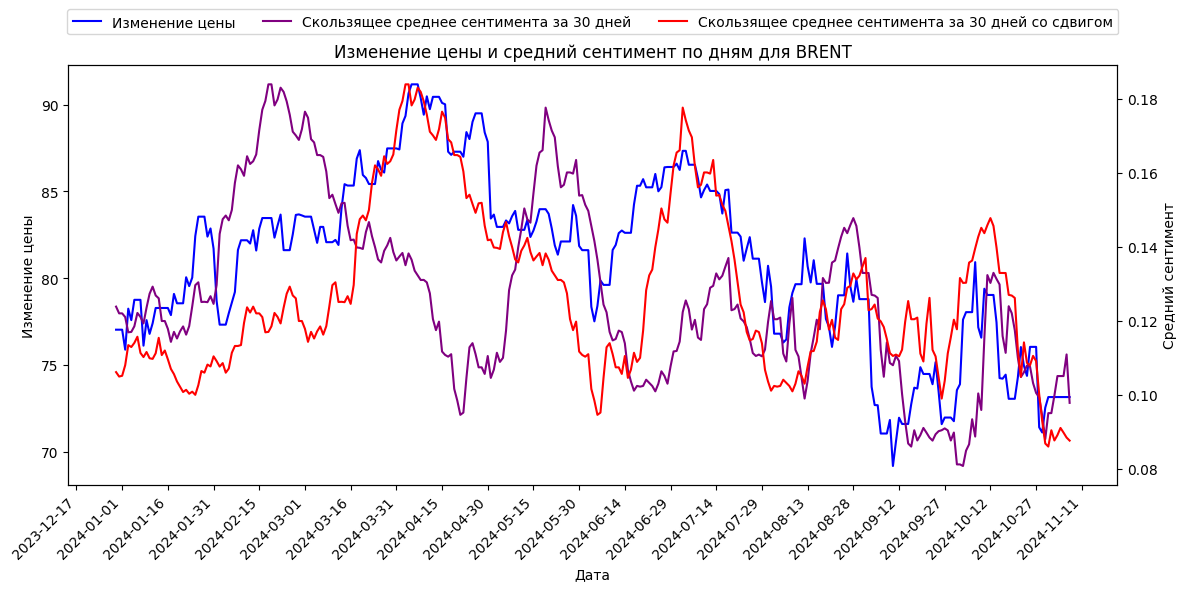

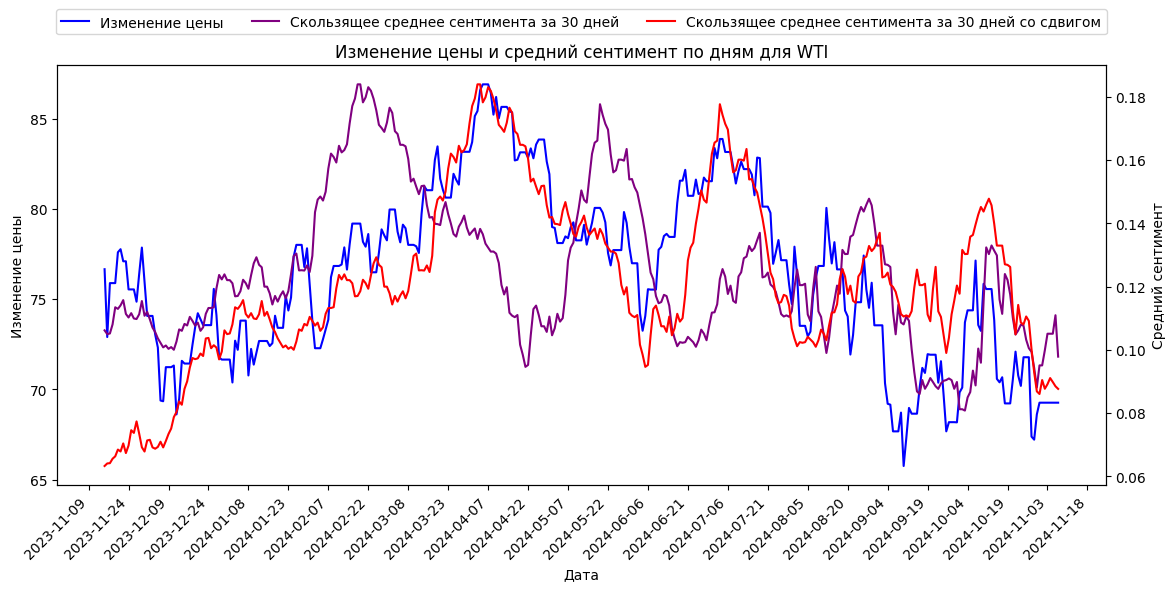

In [468]:

for asset_name in ['BRENT', 'WTI']:
    temp = daily_sentiment.iloc[45:].loc[daily_sentiment.asset_name == asset_name]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(temp['business_date'], temp['close'], color='blue', label='Изменение цены')
    ax1.set_xlabel('Дата')
    ax1.set_ylabel('Изменение цены')
    ax1.tick_params(axis='y')

    # date formating
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Интервал в 15 дней, можно изменить по необходимости

    # second axis
    ax2 = ax1.twinx()
    ax2.plot(temp['business_date'], temp['avg_finbert_sentiment_ma_30'], color='purple', label='Скользящее среднее сентимента за 30 дней')
    ax2.plot(temp['business_date'], temp['avg_finbert_sentiment_ma_30_shifted_45'], color='red', label='Скользящее среднее сентимента за 30 дней со сдвигом')
    ax2.set_ylabel('Средний сентимент')
    ax2.tick_params(axis='y')

    # legends concat
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

    plt.title(f'Изменение цены и средний сентимент по дням для {asset_name}')
    fig.autofmt_xdate(rotation=45)  # Поворот меток для улучшения читаемости

    plt.tight_layout()
    plt.show()

Train MAPE: 0.0203
Test MAPE: 0.0877
Train MSE: 3.8448
Test MSE: 45.0735


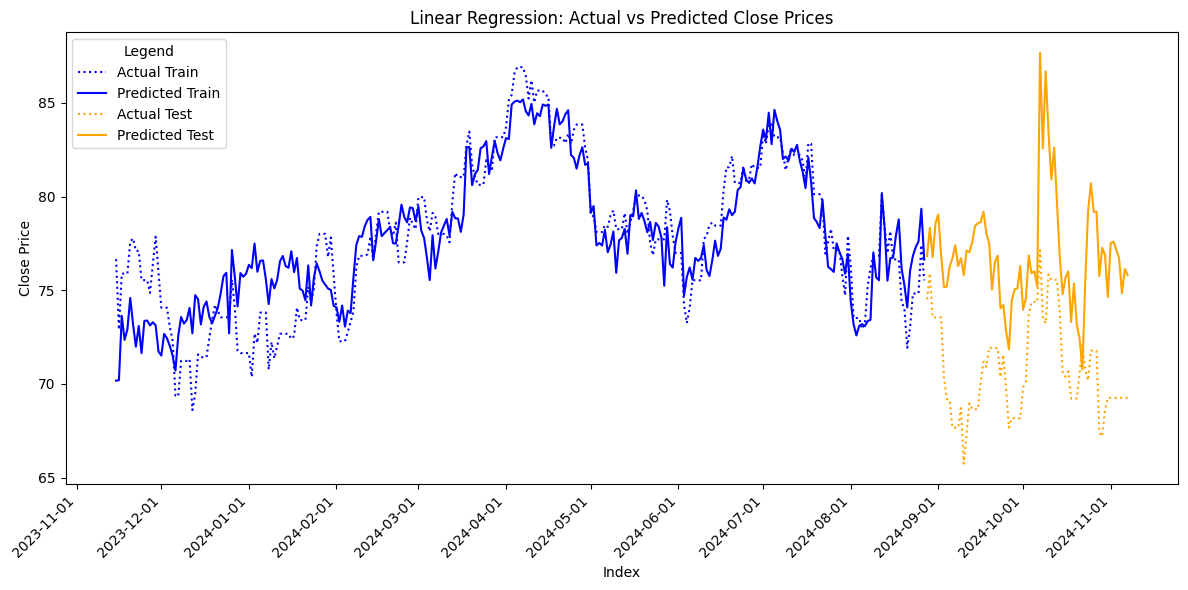

In [469]:
# fitting ols model just to chek how it works with this data
# creating train and test without shuffle

dates = daily_sentiment.loc[daily_sentiment.asset_name == 'WTI', 'business_date']
X = daily_sentiment.loc[daily_sentiment.asset_name=='WTI'].drop(columns=['close','ticker','asset_name','business_date'])
y = daily_sentiment.loc[daily_sentiment.asset_name=='WTI']['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
dates_train, dates_test = train_test_split(dates, test_size=0.2, shuffle=False)

# train test block
model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f"Train MAPE: {train_mape:.4f}")
print(f"Test MAPE: {test_mape:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")


# watching results
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train.values, label='Actual Train', color='blue', linestyle='dotted')
plt.plot(dates_train, y_train_pred, label='Predicted Train', color='blue')
plt.plot(dates_test, y_test.values, label='Actual Test', color='orange', linestyle='dotted')
plt.plot(dates_test, y_test_pred, label='Predicted Test', color='orange')
plt.title("Linear Regression: Actual vs Predicted Close Prices")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend(title="Legend")

# date formating
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Выставляем метки каждый месяц
plt.gcf().autofmt_xdate(rotation=45)  

plt.tight_layout()
plt.show()

In [490]:
daily_sentiment['business_date'] = pd.to_datetime(daily_sentiment['business_date']).dt.date


with engine.connect() as connection:
    existing_records = pd.read_sql("SELECT ticker, business_date FROM daily_finbert_sentiment", con=connection)
existing_records['business_date'] = pd.to_datetime(existing_records['business_date']).dt.date
existing_records


,ticker,asset_name,business_date,close,avg_finbert_sentiment,sentiment_std,weighted_avg_finbert_sentiment,avg_finbert_sentiment_lag1,weighted_avg_finbert_sentiment_lag1,avg_finbert_sentiment_diff1,...,weighted_finbert_sentiment_acceleration,avg_finbert_sentiment_ma_7,weighted_avg_finbert_sentiment_ma_7,avg_finbert_sentiment_ma_15,weighted_avg_finbert_sentiment_ma_15,avg_finbert_sentiment_ma_30,weighted_avg_finbert_sentiment_ma_30,price_change,avg_finbert_sentiment_ma_30_shifted_45,weighted_avg_finbert_sentiment_ma_30_shifted_45
0,BZ=F,BRENT,2023-11-15,81.18,0.188406,0.526980,0.147026,0.151329,0.113070,0.037077,...,-0.070370,0.114990,0.074302,0.124475,0.072338,0.106174,0.054185,-1.29,0.063315,0.011712
1,BZ=F,BRENT,2023-11-16,77.42,0.118699,0.504596,0.070196,0.188406,0.147026,-0.069707,...,-0.110786,0.114022,0.074867,0.123320,0.074358,0.104979,0.053315,-3.76,0.064124,0.011392
2,BZ=F,BRENT,2023-11-17,80.61,0.053232,0.506171,0.036326,0.118699,0.070196,-0.065467,...,0.042959,0.106818,0.075072,0.113429,0.065694,0.105191,0.054508,3.19,0.064204,0.011301
3,BZ=F,BRENT,2023-11-18,80.61,0.053232,0.506171,0.036326,0.053232,0.036326,-0.065467,...,0.042959,0.106818,0.075072,0.108623,0.065730,0.108062,0.058564,0.00,0.065608,0.013340
4,BZ=F,BRENT,2023-11-19,80.61,0.053232,0.506171,0.036326,0.053232,0.036326,-0.065467,...,0.042959,0.106818,0.075072,0.108623,0.065730,0.113465,0.064331,0.00,0.066370,0.015960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,CL=F,WTI,2024-11-03,69.26,0.056338,0.557733,0.068954,0.056338,0.068954,0.056338,...,0.104918,0.031676,0.015111,0.053691,0.061478,0.105111,0.065488,0.00,0.089162,0.011819
714,CL=F,WTI,2024-11-04,69.26,0.056338,0.557733,0.068954,0.056338,0.068954,0.056338,...,0.104918,0.016381,0.007077,0.053691,0.061478,0.105111,0.065488,0.00,0.091098,0.011747
715,CL=F,WTI,2024-11-05,69.26,0.056338,0.557733,0.068954,0.056338,0.068954,0.056338,...,0.104918,0.028169,0.020529,0.064190,0.083117,0.105111,0.065488,0.00,0.089834,0.011587
716,CL=F,WTI,2024-11-06,69.26,0.056338,0.557733,0.068954,0.056338,0.068954,0.056338,...,0.104918,0.056338,0.068954,0.073360,0.063895,0.110950,0.069126,0.00,0.088502,0.009400


In [488]:
merged = daily_sentiment.merge(existing_records, on=['ticker', 'business_date'], how='left', indicator=True)

# no need to upload already existed ticker-dates
new_records = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
new_records.to_sql(
            name='daily_finbert_sentiment',
            con=engine,
            if_exists='append',
            index=False,
        )

718

In [491]:
# matplotlib is for github, and plotly is for happiness

for asset_name in ['BRENT', 'WTI']:
    temp = daily_sentiment.loc[daily_sentiment.asset_name == asset_name]

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=temp['business_date'],
        y=temp['close'],
        mode='lines',
        name='Изменение цены',
        line=dict(color='blue'),
        yaxis='y1'
    ))


    fig.add_trace(go.Scatter(
        x=temp['business_date'],
        y=temp['weighted_avg_finbert_sentiment_ma_30_shifted_45'],
        mode='lines',
        name='weighted_avg_finbert_sentiment_ma_30_shifted_45',
        line=dict(color='purple'),
        yaxis='y2'
    ))
    
    fig.add_trace(go.Scatter(
        x=temp['business_date'],
        y=temp['avg_finbert_sentiment_ma_30_shifted_45'],
        mode='lines',
        name='avg_finbert_sentiment_ma_30_shifted_45',
        line=dict(color='red'),
        yaxis='y2'
    ))

    fig.update_layout(
        title=f'Изменение цены и средний сентимент по дням для {asset_name}',
        xaxis=dict(title='Дата'),
        yaxis=dict(title='Изменение цены', titlefont=dict(color='blue'), tickfont=dict(color='blue')),
        yaxis2=dict(title='Средний сентимент', overlaying='y', side='right', titlefont=dict(color='purple'), tickfont=dict(color='purple')),
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
    )

    # Отображаем график
    fig.show()